# Models results visualization

### Imports

In [1]:
import os
import re
import glob
import os
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin, BaseEstimator

import sys

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVR
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from rumination_experiment_transformers_averaged_CDS import *

import warnings

warnings.filterwarnings("ignore")


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load pickled results

In [31]:
results_all_pe = pd.read_pickle("../public_data/results/models_pickles/pe_results_with_external-p.pkl")
results_all_ern = pd.read_pickle("../public_data/results/models_pickles/ern_results_with_external-p.pkl")

In [32]:
columns = [
    'mean_train_r2', 
    'mean_cv_r2', 
    'p-value', 
    'external_score', 
    'external_p-value' , 
    'scale', 
    'model'
]

In [33]:
results_all_ern[columns]

,mean_train_r2,mean_cv_r2,p-value,external_score,external_p-value,scale,model
0,0.212917,0.142738,0.000999,-0.087499,0.379620,STAI-T,kr
1,0.108733,0.012977,0.023976,-0.147534,0.274725,DASS-21 Anx,svr
2,0.208191,0.071807,0.006993,0.019947,0.093906,SES,kr
3,0.125939,0.090101,0.001998,0.012885,0.124875,BIS,en
4,0.088616,0.024156,0.006993,-0.074879,0.647353,Checking,svr
5,0.037457,0.013701,0.024975,-0.154004,0.936064,OCI-R,svr
6,0.027990,0.005853,0.040959,-0.192910,0.763237,Hoarding,svr
7,0.105856,0.000471,0.053946,-0.165128,0.916084,Neutralizing,en
8,0.092647,0.030011,0.015984,0.006548,0.214785,Obsessing,kr
9,0.092813,0.004296,0.056943,-0.103933,0.890110,Ordering,kr


In [34]:
results_all_pe[columns]

,mean_train_r2,mean_cv_r2,p-value,external_score,external_p-value,scale,model
0,0.046953,0.008272,0.042957,0.017547,0.155844,STAI-T,kr
1,0.053761,-0.002676,0.079920,-0.083297,0.878122,DASS-21 Anx,kr
2,0.081662,-0.001863,0.081918,-0.076364,0.609391,SES,kr
3,0.047343,0.010798,0.044955,0.048408,0.052947,BIS,en
4,0.000000,-0.001789,0.050949,-0.011281,0.898102,Checking,en
5,-0.005810,-0.010129,0.191808,-0.003620,0.320679,OCI-R,svr
6,0.020164,0.003646,0.031968,-0.114503,0.421578,Hoarding,en
7,-0.001815,-0.066601,0.728272,-0.042352,0.198801,Neutralizing,kr
8,0.034435,0.002304,0.083916,-0.046862,0.836164,Obsessing,kr
9,0.000000,-0.050335,0.609391,-0.005175,0.726274,Ordering,en


## Prepare data for visualization

Chose ERN/Pe models for visualization

In [9]:
# condition = 'ern' | 'pe'
condition = 'ern'

In [10]:
current_results_all = results_all_ern if condition == 'ern' else results_all_pe

Enlarge results close to 0 for visibility

In [11]:
current_results_all['external_score'] = current_results_all['external_score'] .apply(lambda x: -0.0025 if abs(x)<0.002 else x)
current_results_all['mean_cv_r2'] = current_results_all['mean_cv_r2'] .apply(lambda x: -0.0025 if abs(x)<0.002 else x)

Split each record to two records: internal and external for drawing

In [12]:
df = pd.DataFrame()

# results = results.reset_index()  # make sure indexes pair with number of rows
for index, row in current_results_all.iterrows():
    #####internal######
    data = {
            "train_score": row["mean_train_r2"],
            "test_score": row["mean_cv_r2"],
            "sd": row["std_cv_r2"],
            "p-value": row["p-value"],
            "scale": row["scale"],
            "dataset": 'internal',
        }

    df = df.append(data, ignore_index=True)
    
    #####external######
    data = {
            "train_score": 0,
            "test_score": row["external_score"],
            "sd": 0,
            "p-value": row['external_p-value'],
            "scale": row["scale"],
            "dataset": 'external',
        }

    df = df.append(data, ignore_index=True)

In [13]:
df_external = df[df['dataset'] == 'external']
df_internal = df[df['dataset'] == 'internal']

Duplicate observations with defined in DF standard deviation - hack for plotting error bars

In [14]:
duplicates=1000

#duplicate observations to get good std bars
df_internal_copy = df_internal.loc[df_internal.index.repeat(duplicates)].copy()
df_internal_copy['test_score'] = np.random.normal(df_internal_copy['test_score'].values,df_internal_copy['sd'].values)

Concat external and internal datasets

In [15]:
df_all = pd.concat([df_internal_copy, df_external], ignore_index=True)

## Plots

In [16]:
def set_ern_significance_stars():
    # DASS
    plt.text(-.27,.09, '*', fontsize = 7)
    # plt.text(0.07,1.5, '*', fontsize = 5)
    
    # STAI-T
    plt.text(0.66,0.19, '**', fontsize = 7)
#     # plt.text(-0.014,2.5, '*', fontsize = 16)

    # BIS
    plt.text(1.66,0.15, '**', fontsize = 7)
#     # plt.text(-0.024,3.35, '*', fontsize = 5)

    # RRQ
    plt.text(2.67,0.09, '**', fontsize = 7)
    plt.text(3.14,0.09, '*', fontsize = 7)

    # WBSI
    plt.text(3.73,0.04, '+', fontsize = 7, weight='bold')
#     # plt.text(0.07,5.5, '*', fontsize = 16)

    # OT
    plt.text(4.67,0.16, '**', fontsize = 7)
    plt.text(5.14, 0.08, '+', fontsize = 7, weight='bold')

    # IUS-P
    plt.text(5.665,0.29, '**', fontsize = 7)
#     # plt.text(-0.014,7.5, '*', fontsize = 16)

    # IUS-I
    plt.text(6.743, 0.07, '*', fontsize = 7)
    plt.text(7.15, 0.07, '+', fontsize = 7, weight='bold')

#     # OCI-R
    plt.text(7.73,0.093, '*', fontsize = 7)
#     # plt.text(0.07,7.5, '*', fontsize = 16)

    # checking
    plt.text(8.67,0.21, '**', fontsize = 7)
#     # plt.text(0.07,8., '*', fontsize = 16)

    #hoarding
    plt.text(9.66, 0.035, '**', fontsize = 7)
#     # plt.text(0.07,11.5, '*', fontsize = 16)

    #obsessing
    plt.text(10.73,0.09, '*', fontsize = 7)
#     # plt.text(0.07,12.5, '*', fontsize = 16)

    # ordering
    plt.text(11.725, 0.12, '+', fontsize = 7, weight='bold')
#     # plt.text(0.07,13.5, '*', fontsize = 16)
    
    # neutralizing
    plt.text(12.725,0.11, '+', fontsize = 7,weight='bold')
#     # plt.text(0.07,12.5, '*', fontsize = 16)
    
#     # washing
#     # plt.text(0.07,13.95, '*', fontsize = 16)
#     # plt.text(0.07,13.5, '*', fontsize = 16)

    # SES
    plt.text(14.66, 0.16, '**', fontsize = 7)
    plt.text(15.14, 0.03, '+', fontsize = 7, weight='bold')

In [67]:
def set_pe_significance_stars():
    # DASS
    plt.text(-.27,.047, '+', fontsize = 7, weight='bold')
    # plt.text(0.07,1.5, '*', fontsize = 5)
    
    # STAI-T
    plt.text(0.725,0.045, '*', fontsize = 7)
#     # plt.text(-0.014,2.5, '*', fontsize = 16)

    # BIS
    plt.text(1.735,0.035, '*', fontsize = 7)
    plt.text(2.137,0.06, '+', fontsize = 7, weight='bold')

    # RRQ
    plt.text(2.67,0.1, '**', fontsize = 7)
    plt.text(3.14,0.116, '*', fontsize = 7)

    # WBSI
    plt.text(3.73,0.02, '+', fontsize = 7, weight='bold')
    plt.text(4.13,0.031, '*', fontsize = 7, weight='bold')

    # OT
    # plt.text(4.67,0.16, '**', fontsize = 7)
    # plt.text(5.14, 0.08, '+', fontsize = 7, weight='bold')

    # IUS-P
    plt.text(5.665,0.115, '**', fontsize = 7)
    plt.text(6.07,0.195, '**', fontsize = 7)

    # IUS-I
    # plt.text(6.743, 0.07, '*', fontsize = 7)
    # plt.text(7.15, 0.07, '+', fontsize = 7, weight='bold')

    # OCI-R
    # plt.text(7.73,0.093, '*', fontsize = 7)
    # plt.text(0.07,7.5, '*', fontsize = 16)

    # checking
    plt.text(8.74,0.010, '*', fontsize = 7)
#     # plt.text(0.07,8., '*', fontsize = 16)

    #hoarding
    plt.text(9.73, 0.029, '*', fontsize = 7)
#     # plt.text(0.07,11.5, '*', fontsize = 16)

    #obsessing
    plt.text(10.73,0.052, '*', fontsize = 7)
#     # plt.text(0.07,12.5, '*', fontsize = 16)

    # ordering
    # plt.text(11.725, 0.12, '+', fontsize = 7, weight='bold')
#     # plt.text(0.07,13.5, '*', fontsize = 16)
    
    # neutralizing
    # plt.text(12.725,0.11, '+', fontsize = 7,weight='bold')
#     # plt.text(0.07,12.5, '*', fontsize = 16)
    
#     # washing
    plt.text(13.72,0.16, '*', fontsize = 7)
#     # plt.text(0.07,13.5, '*', fontsize = 16)

    # SES
    plt.text(14.73, 0.04, '*', fontsize = 7)
    # plt.text(15.14, 0.03, '+', fontsize = 7, weight='bold')

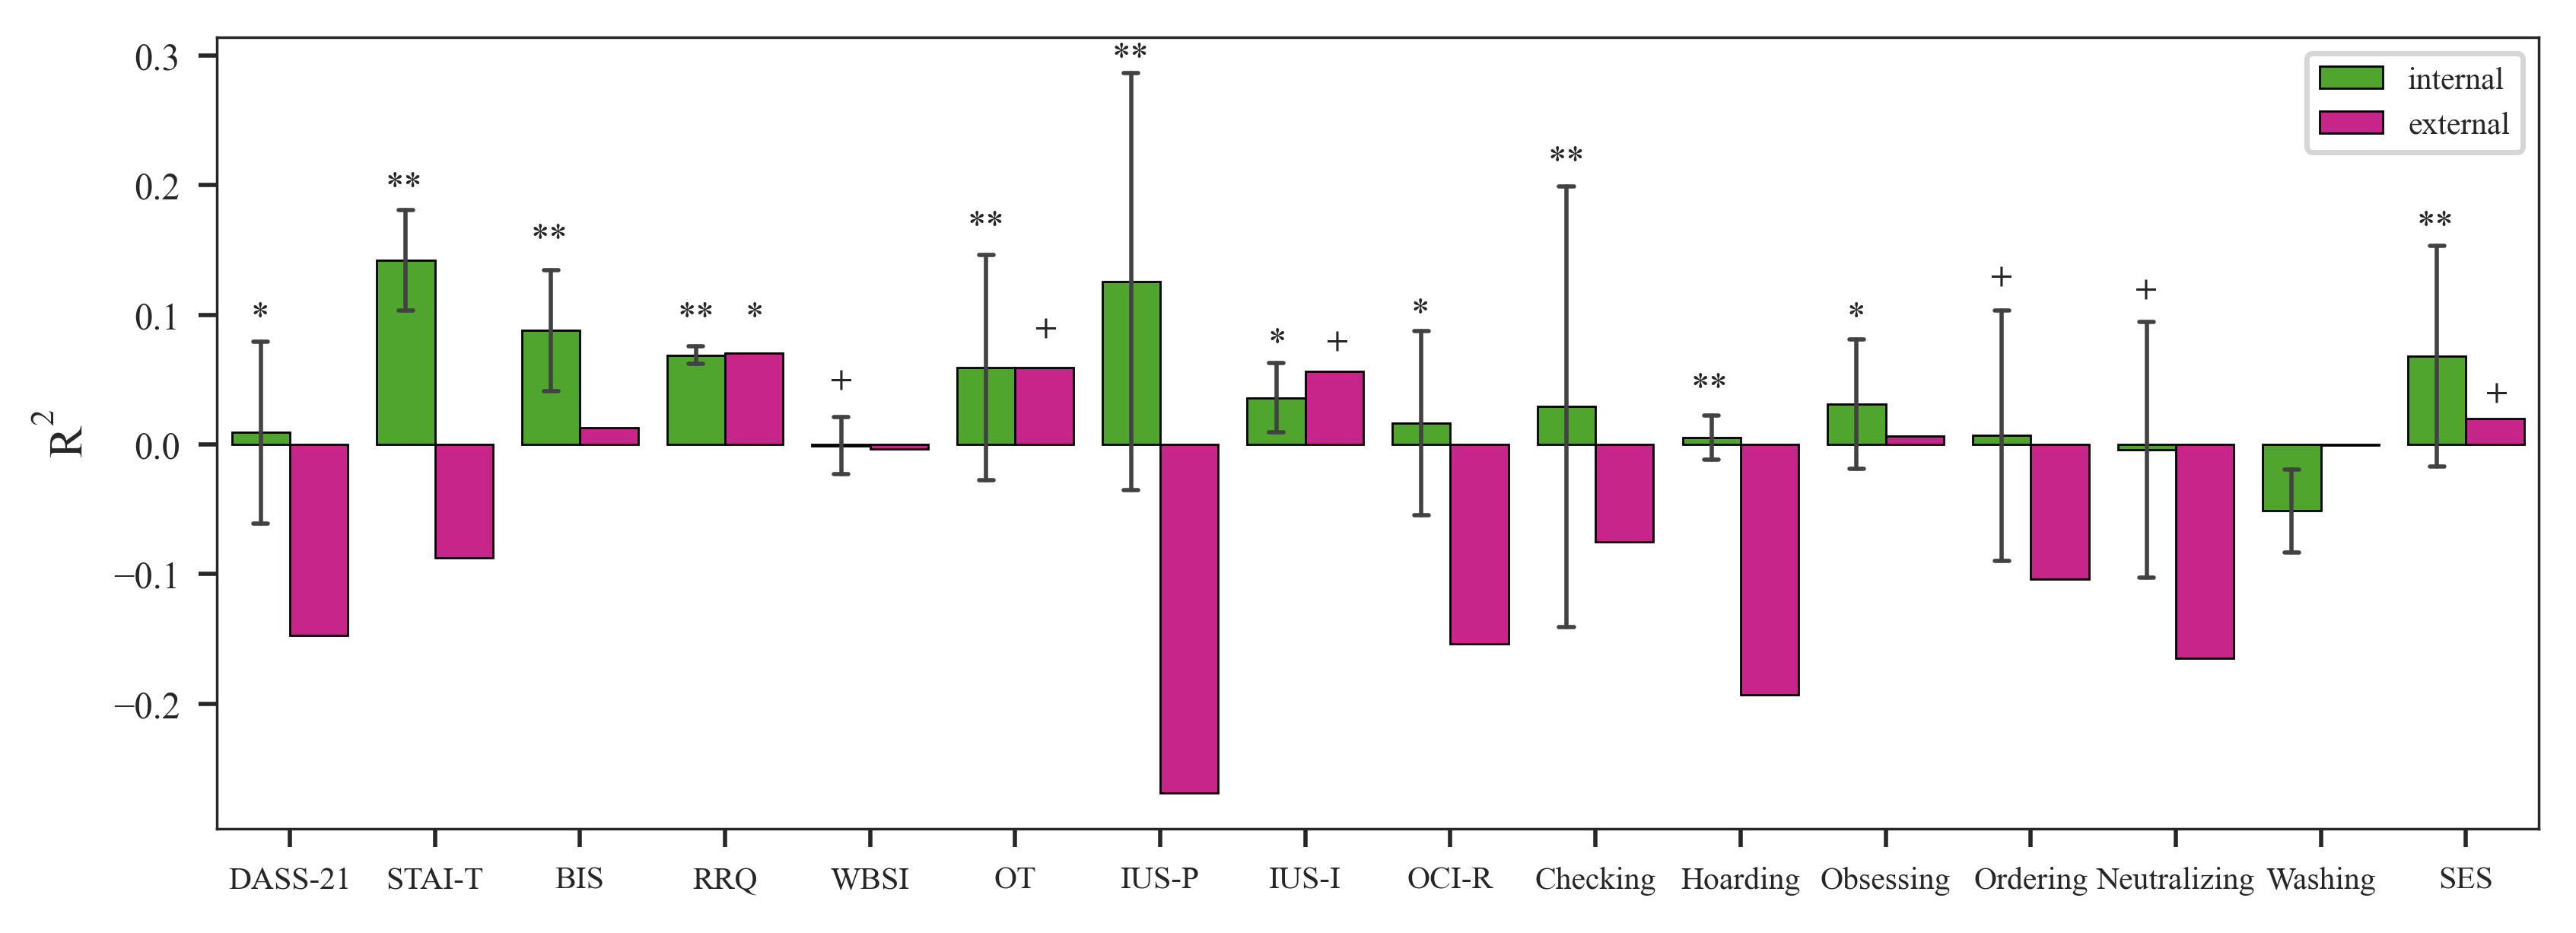

In [73]:
import seaborn as sns
import matplotlib.pylab as plt

order_list = ['DASS-21 Anx', 'STAI-T', 'BIS', 'RRQ', 
              'WBSI', 'OT', 'IUS-P', 'IUS-I', 'OCI-R', 
              'Checking', 'Hoarding', 'Obsessing', 'Ordering',
              'Neutralizing', 'Washing', 'SES']

labels = [
    "DASS-21",
    "STAI-T",
    "BIS",
    "RRQ",
    "WBSI",
    "OT",
    "IUS-P",
    "IUS-I",
    "OCI-R",
    "Checking",
    "Hoarding",
    "Obsessing",
    "Ordering",
    "Neutralizing",
    "Washing",
    "SES",

]

sns.set_style("white")

cm = 1/2.54
dpi = 500

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [20*cm,7*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 9
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 9
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5

plt.tick_params(axis='both', which='major', bottom=True, left = True)

custom_palette = ["#4dac26",  '#d01c8b']

sns.set_palette(custom_palette)

ax = sns.barplot(
        y='test_score',
        x='scale',
        hue='dataset',
        order=order_list,
        data=df_all, 
        orient ='v',
        ci='sd',
        capsize=.1,
        errwidth = 0.8,
        ec='k',
        linewidth=0.4,
        saturation=0.9,
)

ax.set(ylabel="$\mathregular{R^{2}}$", xlabel='')

plt.legend(fontsize=6)
plt.xticks([i for i in range(16)], labels)

# whether significance marks
set_significance_markers = True

if set_significance_markers:
    set_ern_significance_stars() if condition == 'ern' else set_pe_significance_stars()

plt.show()

# ax.figure.savefig(f"../public_data/figures/models_results/{condition}_scores-detailed_summary_p_{set_significance_markers}.png", bbox_inches='tight')